# Teaching: Estimating the difficulty of teaching problems
Natalia Vélez, October 2020

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

## Set up an example problem

Example problem:

In [2]:
empty_square = [
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0]
]

squareA = [
     [0,0,0,0,0,0],
     [0,1,1,1,1,0],
     [0,1,1,1,1,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0]
]

squareB = [
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0],
     [0,1,1,1,1,0],
     [0,1,1,1,1,0],
     [0,0,0,0,0,0]
]

squareC = [
     [0,0,0,0,0,0],
     [0,1,1,0,0,0],
     [0,1,1,0,0,0],
     [0,1,1,0,0,0],
     [0,1,1,0,0,0],
     [0,0,0,0,0,0]
]

squareD = [
     [0,0,0,0,0,0],
     [0,0,0,1,1,0],
     [0,0,0,1,1,0],
     [0,0,0,1,1,0],
     [0,0,0,1,1,0],
     [0,0,0,0,0,0]
]

example_problem = np.array([squareA, squareB, squareC, squareD])
print(example_problem.shape)

(4, 6, 6)


Helper: Plot problems

In [3]:
def plot_problem(problem):
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    opt_labels = 'ABCD'

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='gray_r', cbar=False,
                         linewidths=2, linecolor='#808080')
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx])     

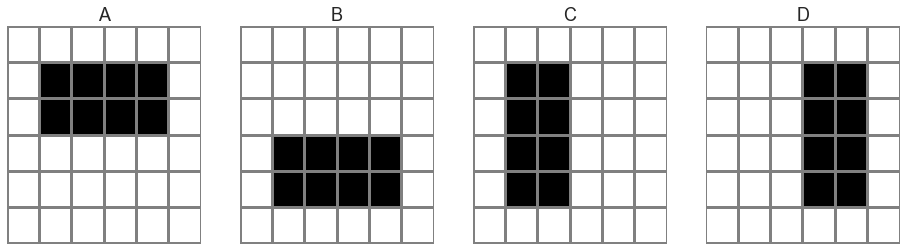

In [4]:
plot_problem(example_problem)

## Evaluate examples literally

Helper: Plot examples

In [5]:
true_concept = np.array(squareC)
example_mask = np.array([
    [1,1,1,1,1,1],
    [1,0,1,1,1,1],
    [1,1,0,1,1,1],
    [1,1,0,1,1,1],
    [1,1,1,1,1,1],
    [1,1,1,1,1,1],
]).astype(np.bool)

example = np.ma.masked_array(true_concept, mask=example_mask).astype(np.float) # keeps the 0 values

def plot_example(ex):
    example_view = ex.filled(0.5)
    ax = sns.heatmap(example_view, vmin=0, vmax=1, 
                     cmap='gray_r', cbar=False, square = True,
                     linewidths=1, linecolor='#808080')
    ax.set(xticks=[],yticks=[])

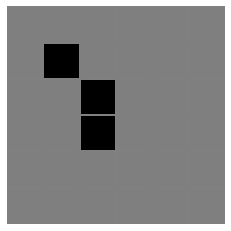

In [6]:
plot_example(example)

All possible combinations of examples:

In [5]:
n = 36
ex_1 = [[i] for i in  range(n)]
ex_2 = [[i,j] for i in range(n) for j in range(i+1,n)]
ex_3 = [[i,j,k] for i in range(n) for j in range(i+1,n) for k in range(j+1,n)]

print('Singles: %i' % len(ex_1))
print('Doubles: %i' % len(ex_2))
print('Triples: %i' % len(ex_3))

Singles: 36
Doubles: 630
Triples: 7140


Check if a list of indices fully disambiguates a concept:

In [6]:
def idx_to_mask(idx):
    '''
    returns 6x6 mask given list of indices (indices go thru rows horizontally)
    '''
    ex = np.zeros(36)
    ex[idx] = 1
    ex = np.reshape(ex, (6,6))
    ex = ex.astype(np.bool)
    
    return ex

def disambiguates(idx, target, problem):
    '''
    tells you whether or not a specific index disambiguates target grid from the other ones in the problem 
    
    idx is list of indices you are checking
    target is the index of the grid you are trying to disambiguate
    problem is the problem
    '''
    mask = idx_to_mask(idx)
    true_h = problem[target,:,:] # finding grid you are trying to disambiguate
    
    any_matches = False
    for i in range(problem.shape[0]): # number of concepts to disambiguate (4)
        if i != target: # loop over grids that are not the one you are trying to disambiguate
            distractor_h = problem[i,:,:] # finding grid to test 
            any_matches = np.array_equal(true_h[mask], distractor_h[mask])
            if any_matches: # returns true if it does not disambiguate 
                break
                
    return not any_matches

How many examples do you need to disambiguate the concept?

In [7]:
all_examples = ex_1+ex_2+ex_3 # list of all combos of coordinates

def minimum_all(target, problem, example_space=all_examples):
    '''
    target is the index of the square you're trying to disambiguate
    problem is an array of the problems
    example space is the list of all combinations of squares (indices) (size 1, 2, and 3 in this case) to test 
    
    requires that example_space goes from smaller to larger
    '''
    n = np.nan
    ex_mask = np.empty((6,6))
    for ex in example_space:
        if disambiguates(ex, target, problem):
            ex_mask = idx_to_mask(ex)
            n = len(ex)
            break
            
    return n, ex_mask

In [35]:
# for i in range(4):
#     n, _ = minimum_all(i, example_problem)
#     print(n)

**new:** Disambiguating using only positive examples

In [8]:
def positive_indices(concept):
    '''
    returns all combos of positive indices for a concept (a concept is a 6x6 array)
    '''
    pos_coords = np.nonzero(concept) # returns indices of concept (where there are ones)
    pos_idx = np.ravel_multi_index(pos_coords, (6,6)) # returns indices (linear)
    pos_idx = list(pos_idx)
    n_idx = len(pos_idx)

    indices = []
    
    # find length of indices
    for i in range(n_idx):
        indices.append([pos_idx[i]])
        for j in range(i+1, n_idx):
            indices.append([pos_idx[i],pos_idx[j]])
            for k in range(j+1, n_idx):
                indices.append([pos_idx[i],pos_idx[j],pos_idx[k]])
    
    # sort indices by length
    indices = sorted(indices, key=len)
    return indices

def minimum_positive(target, problem):
    pos_examples = positive_indices(problem[target,:,:])
    n, ex_mask = minimum_all(target, problem, pos_examples)
    return n, ex_mask

### Filling dataframe with k values

For two cases: pos/neg and pos examples

In [33]:
from make_df import make_df_from_spreadsheet

filename = '/Users/aliciachen/Dropbox/teaching_models/teaching_stimuli - Sheet1 (5).csv'
example_df = make_df_from_spreadsheet(filename)

In [36]:
def add_example_difficulty(df):
    
    df_copy = df.copy()

    added_columns = ['k_1', 'k_2', 'k_3', 'k_4']
    columns = df_copy.columns.tolist()

    for index, row in df_copy.iterrows(): 
        sample_problem = df_copy.loc[index,columns].to_numpy(dtype=object)
        sample_problem = np.array([item for item in sample_problem])
        for i in range(4): 
            df_copy.loc[index, added_columns[i]] = minimum_all(i, sample_problem)[0]

    # saving
    df_copy.to_csv('examples_output.csv')
    
def add_positive_example_difficulty(df):
    
    df_copy = df.copy()

    added_columns = ['k_1', 'k_2', 'k_3', 'k_4']
    columns = df_copy.columns.tolist()

    for index, row in df_copy.iterrows(): 
        sample_problem = df_copy.loc[index,columns].to_numpy(dtype=object)
        sample_problem = np.array([item for item in sample_problem])
        for i in range(4): 
            df_copy.loc[index, added_columns[i]] = minimum_positive(i, sample_problem)[0]

    # saving
    df_copy.to_csv('pos_examples_output.csv')

In [34]:
add_example_difficulty(example_df)
add_positive_example_difficulty(example_df)